# BEAMFORMING

https://pysdr.org/content/doa.html

In [27]:
use_matplotlib = False

import numpy as np
if use_matplotlib:
    import matplotlib.pyplot as plt
else:
    import plotly.graph_objects as go
import beamforming

## Create base signal tx_signal with f = 20kHz
$ tx\_signal = {e^{j2\pi ft}} = cos(2\pi ft) + j \ sin(2\pi ft) $ 

with
$ \phi = 0 $ 

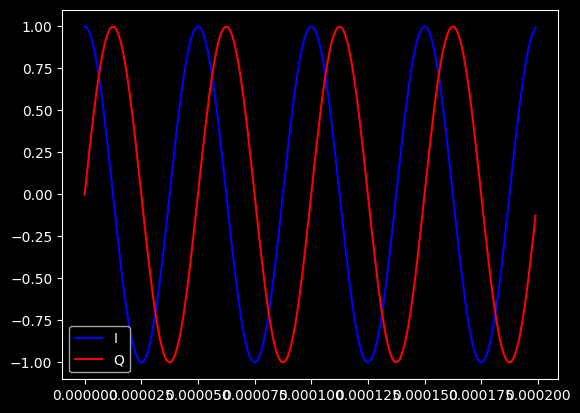

In [28]:
sample_rate = 1e6
N = 10000 # number of samples to simulate

# Create a tone to act as the transmitter signal
t = np.arange(N)/sample_rate # time vector
f_tone = 0.02e6
tx_signal = beamforming.create_IQ_signal(f_tone, t)

if use_matplotlib:
    plt.style.use('dark_background')
    plt.plot(t[0:200], np.real(tx_signal[0:200]), 'b', label="I")
    plt.plot(t[0:200], np.imag(tx_signal[0:200]), 'r', label="Q")
    plt.legend()
    plt.show()
else:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=t[0:200], y=np.real(tx_signal[0:200]), mode='lines', name='I'))
    fig.add_trace(go.Scatter(x=t[0:200], y=np.imag(tx_signal[0:200]), mode='lines', name='Q'))
    fig.update_layout(template="plotly_dark")
    fig.show()

## Create table of signal phases

$ steering\_vectors = e^{-j2\pi \ antena\_spacing \ sin(\theta) } $



In [29]:
antena_spacing = 0.5 # half wavelength spacing
antena_rx_nbr = 5
theta_degrees = 35 # direction of arrival (feel free to change this, it's arbitrary)

theta = np.radians(theta_degrees) # convert to radians

steering_vectors = beamforming.create_steering_vectors(antena_rx_nbr, antena_spacing, theta) # Steering Vector
print(steering_vectors) # note that it's 3 elements long, it's complex, and the first element is 1+0j

[ 1.        +0.j         -0.22909436-0.97340422j -0.89503155+0.44600283j
  0.63918771+0.76905076j  0.60216296-0.7983732j ]


## Multiply each signal reception by phases shift

Complex multioplication is equivalent to add a phase shift

$ tx\_signal = {e^{j2\pi ft}} $

$ steering\_vectors = {e^{j2\pi \ phase\_shift}} $

$ steering\_vectors * tx\_signal = {e^{j2\pi phase\_shift}} * {e^{j2\pi ft}} = {e^{j2\pi (ft + phase\_shift)}} $



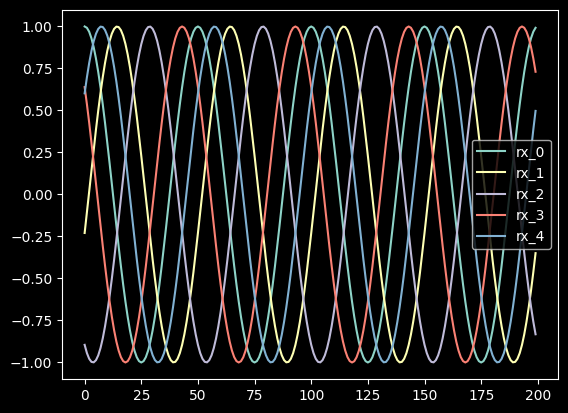

In [30]:
steering_vectors = steering_vectors.reshape(-1,1) # make steering_vectors a column vector
tx_signal = tx_signal.reshape(1,-1) # make tx_signal a row vector

rx_signals = steering_vectors * tx_signal # Simulate the received signal rx_signals through a matrix multiply

if use_matplotlib:
    for rx_signal in range(antena_rx_nbr):
        plt.plot(np.asarray(rx_signals[rx_signal,:]).squeeze().real[0:200], label='rx_' + str(rx_signal))
    plt.legend()
    plt.show()
else:
    fig = go.Figure()
    for rx_signal in range(antena_rx_nbr):
        fig.add_trace(go.Scatter(x=t[0:200], y=np.asarray(rx_signals[rx_signal,:]).squeeze().real[0:200], mode='lines', name='rx_' + str(rx_signal)))
    fig.update_layout(template="plotly_dark")
    fig.show()

## Add some noise

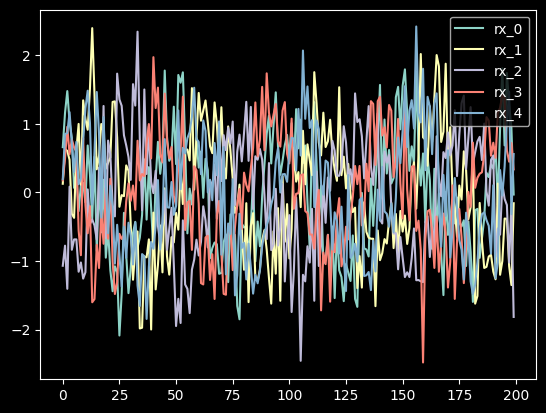

In [31]:
rx_signals = beamforming.generate_noise_on_signal(rx_signals)

if use_matplotlib:
    for id, rx_signal in enumerate(rx_signals):
        plt.plot(np.asarray(rx_signal).squeeze().real[0:200], label='rx_' + str(id))
    plt.legend()
    plt.show()
else:
    fig = go.Figure()
    for id, rx_signal in enumerate(rx_signals):
        fig.add_trace(go.Scatter(x=t[0:200], y=np.asarray(rx_signal).squeeze().real[0:200], mode='lines', name='rx_' + str(id)))
    fig.update_layout(template="plotly_dark")
    fig.show()

# Create beam from 3 receivers

(1, 10000)


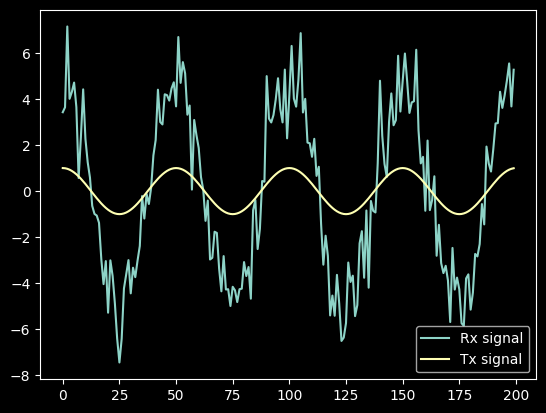

In [32]:
X_weighted = beamforming.beamforming(rx_signals, steering_vectors)
print(X_weighted.shape) # 1x10000

if use_matplotlib:
    plt.plot(np.asarray(X_weighted).squeeze().real[0:200], label="Rx signal") # the asarray and squeeze are just annoyances we have to do because we came from a matrix
    plt.plot(np.asarray(tx_signal).squeeze().real[0:200], label="Tx signal")
    plt.legend()
    plt.show()
else:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=t[0:200], y=np.asarray(X_weighted).squeeze().real[0:200], mode='lines', name="Rx signal"))
    fig.add_trace(go.Scatter(x=t[0:200], y=np.asarray(tx_signal).squeeze().real[0:200], mode='lines', name="Tx signal"))
    fig.update_layout(template="plotly_dark")
    fig.show()

Let simulate 10 antenas 

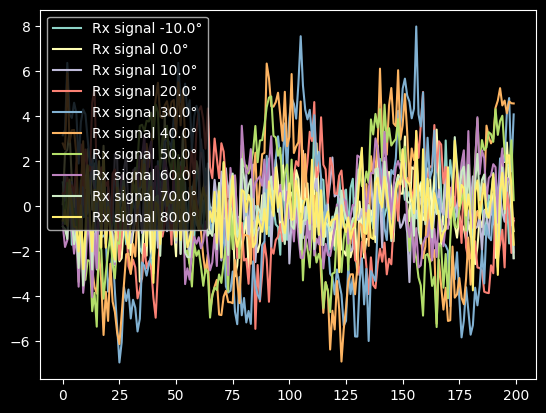

In [33]:
theta_scan = np.linspace(theta_degrees-45, theta_degrees+45, 10)

results = []

if not use_matplotlib:
   fig = go.Figure()

for theta_i in theta_scan:
   w = beamforming.create_steering_vectors(antena_rx_nbr, antena_spacing, np.radians(theta_i))
   X_weighted = beamforming.beamforming(rx_signals, w)
   if use_matplotlib:
      plt.plot(np.asarray(X_weighted).squeeze().real[0:200], label="Rx signal " + str(theta_i) + "°")
   else:
     fig.add_trace(go.Scatter(x=t[0:200], y=np.asarray(X_weighted).squeeze().real[0:200], mode='lines', name="Rx signal " + str(theta_i) + "°"))
if use_matplotlib:
   plt.legend()
   plt.show()
else:   
   fig.add_trace(go.Scatter(x=t[0:200], y=np.asarray(tx_signal).squeeze().real[0:200], mode='lines', name="Tx signal"))
   fig.update_layout(template="plotly_dark") 
   fig.show()

145.04504504504501


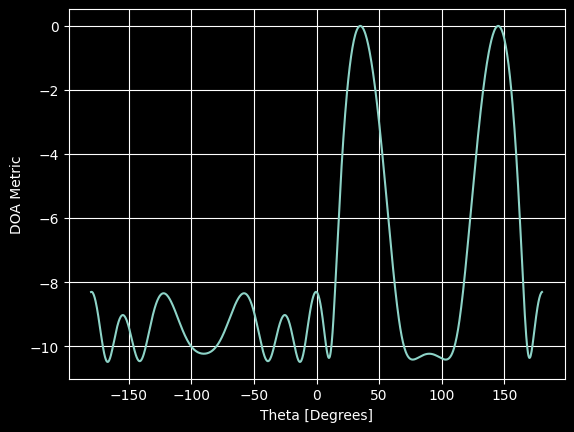

In [34]:
theta_scan = np.linspace(-1*np.pi, np.pi, 1000) # 1000 different thetas between -180 and +180 degrees
results = []
for theta_i in theta_scan:
   w = beamforming.create_steering_vectors(antena_rx_nbr, antena_spacing, theta_i)
   X_weighted = beamforming.beamforming(rx_signals, w)
   results.append(10*np.log10(np.var(X_weighted))) # power in signal, in dB so its easier to see small and large lobes at the same time
results -= np.max(results) # normalize (optional)

# print angle that gave us the max value
print(theta_scan[np.argmax(results)] * 180 / np.pi) # 19.99999999999998

if use_matplotlib:
   plt.plot(theta_scan*180/np.pi, results) # lets plot angle in degrees 
   plt.xlabel("Theta [Degrees]")
   plt.ylabel("DOA Metric")
   plt.grid()
   plt.show()
else:
   fig = go.Figure()
   fig.add_trace(go.Scatter(x=theta_scan*180/np.pi, y=results, mode='lines', name="Rx signal", showlegend=True))
   fig.update_layout(template="plotly_dark")
   fig.show()  

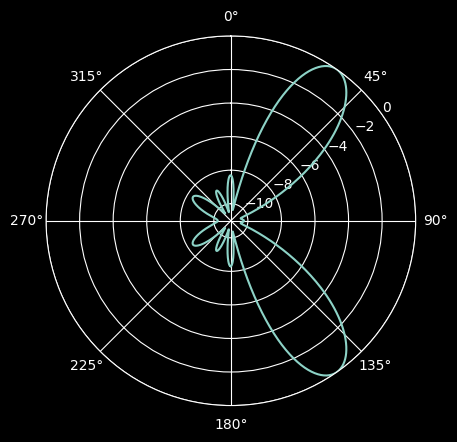

In [35]:

max_val = theta_scan.copy()
max_val.fill(None)
l=1000/4
max_val[np.argmax(results[250:750])+250] = 0

if use_matplotlib:
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.plot(theta_scan, results) # MAKE SURE TO USE RADIAN FOR POLAR
    ax.plot(theta_scan, max_val)
    ax.set_theta_zero_location('N') # make 0 degrees point up
    ax.set_theta_direction(-1) # increase clockwise
    ax.set_rlabel_position(55)  # Move grid labels away from other labels
    plt.show()
else:
    fig = go.Figure()
    fig.add_trace(go.Scatterpolar(r=results, theta=np.degrees(theta_scan), name='scan', mode='lines', showlegend=True))
    fig.add_trace(go.Scatterpolar(r=max_val, theta=np.degrees(theta_scan), name='max', mode='markers+text', showlegend=True, 
                                  text=np.degrees(theta), textposition="top right", textfont=dict(color="Red" ) ))
    fig.update_layout(polar = dict(radialaxis_angle = 90, angularaxis = dict(direction = "clockwise" ), sector=[0, 180]))
    fig.update_layout(template="plotly_dark")
    fig.show()  